## Importing

In [268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [269]:
df = pd.read_csv("/content/bitcoin_price.csv")

In [270]:
df.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Jul 31, 2017",2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000"
1,"Jul 30, 2017",2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"
2,"Jul 29, 2017",2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
3,"Jul 28, 2017",2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
4,"Jul 27, 2017",2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"


##Preprocessing

Making new columns for date,month and year

In [271]:
df["Year"] = pd.to_datetime(df.Date).dt.year
df["Month"] = pd.to_datetime(df.Date).dt.month
df["Date"] = pd.to_datetime(df.Date).dt.day

for i in ['Year', 'Month', 'Date']:
  df[i]=df[i].astype(int)

Removing commas from the column Volume and Market Cap, later in the code I've then converted it to int.

In [272]:
ND = []
for k in ['Volume', 'Market Cap']:
  d = df[k]
  V=[]
  for i in d:
    g = ''
    for j in i:
      if j != ',':
        g+=j
    V.append(g)
  df[k] = pd.DataFrame(V)

###Filling missing values in the Volume column, by predicting them.

Creating separate datasets, one with rows having Volume values, one without.

In [273]:
NAND = df[df['Volume']=='-'].reset_index().drop(['index','Volume'], axis =1)
TR_DT = df[df['Volume']!='-'].reset_index().drop(['index'], axis =1)

In [274]:
Vol = TR_DT.Volume
TR_DT.drop(['Volume'], axis = 1, inplace = True)

Predicting Values using RFC.

In [275]:
from sklearn.ensemble import RandomForestRegressor
model =RandomForestRegressor()
model.fit(TR_DT, Vol)

nan_Vol = pd.DataFrame(model.predict(NAND))
nan_Vol.set_axis(['Volume'], axis = 1, inplace = True)

Merging both the datasets after prediction to create a new dataset that will be used from now onwards.

In [276]:
DF = pd.concat([pd.concat([TR_DT, Vol], axis = 1), pd.concat([NAND, nan_Vol], axis = 1)] , axis = 0)

In [277]:
DF

,Date,Open,High,Low,Close,Market Cap,Year,Month,Volume
0,31,2763.24,2889.62,2720.61,2875.34,45535800000,2017,7,860575000
1,30,2724.39,2758.53,2644.85,2757.18,44890700000,2017,7,705943000
2,29,2807.02,2808.76,2692.80,2726.45,46246700000,2017,7,803746000
3,28,2679.73,2897.45,2679.73,2809.01,44144400000,2017,7,1380100000
4,27,2538.71,2693.32,2529.34,2671.78,41816500000,2017,7,789104000
...,...,...,...,...,...,...,...,...,...
238,2,116.38,125.60,92.28,105.21,1292190000,2013,5,68380734.0
239,1,139.00,139.89,107.72,116.99,1542820000,2013,5,68380734.0
240,30,144.00,146.93,134.05,139.00,1597780000,2013,4,67471318.0
241,29,134.44,147.49,134.00,144.54,1491160000,2013,4,67422569.0


In [278]:
for i in range(1556):
  DF.values[i,4]=int(DF.values[i,4])
  DF.values[i,8]=int(DF.values[i,8])

In [279]:
DF = DF.reset_index().drop(['index'], axis =1)
DF['Volume']=DF['Volume'].astype(int)
DF['Market Cap']=DF['Market Cap'].astype(int)

## EXPLORATORY DATA ANALYSIS

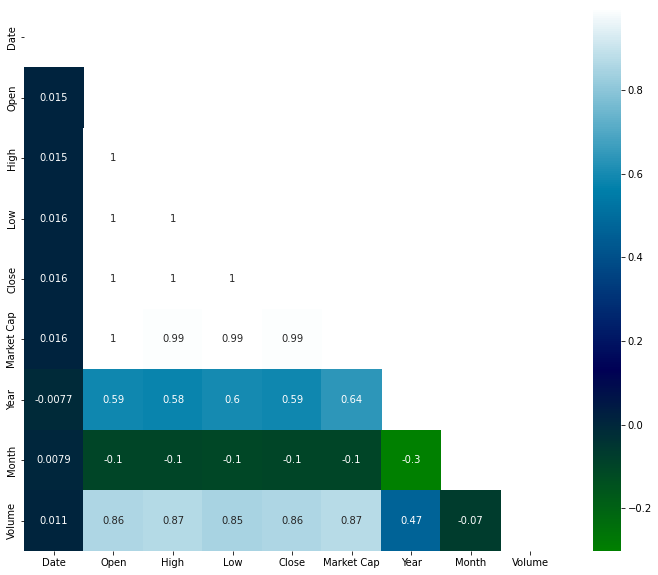

In [280]:
corr = DF.corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask = mask, cmap='ocean');

From the heatmap we can see, all the columns except the data ones are linearly related therefore linear regression would be best.

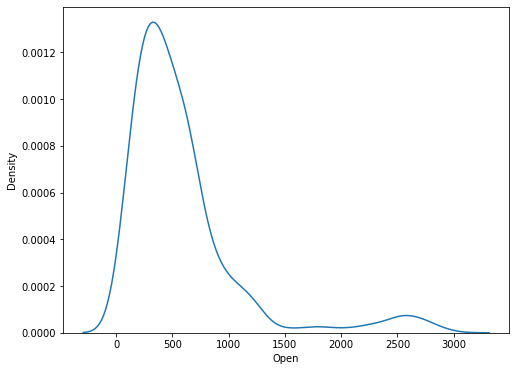

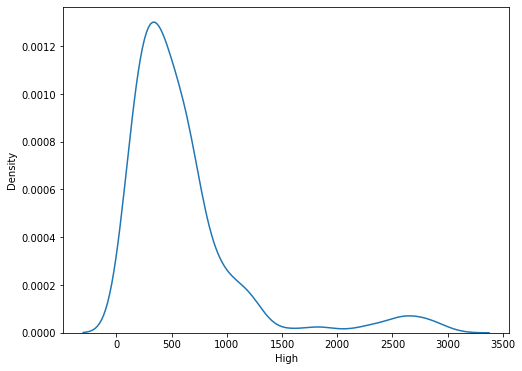

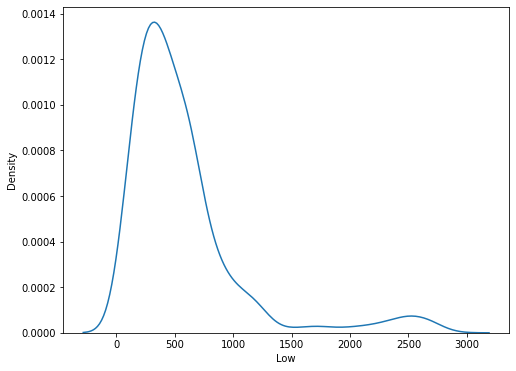

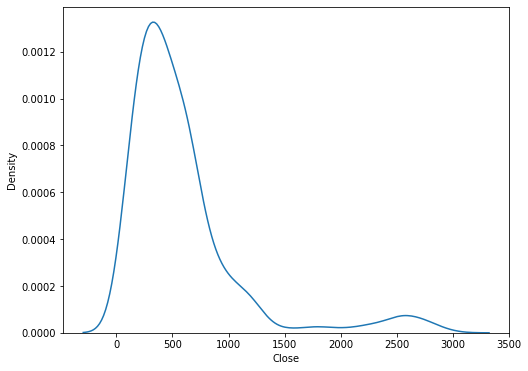

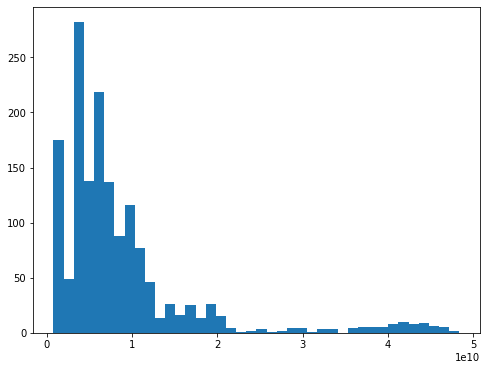

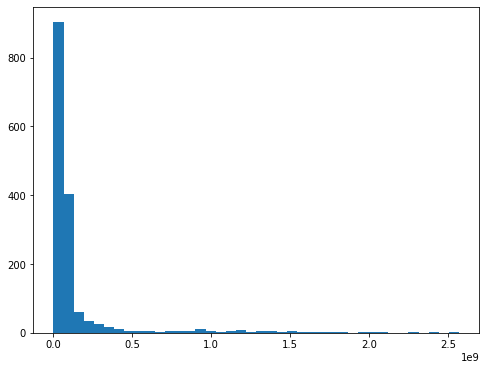

In [343]:
for i in DF.columns:
   if (i!='Volume' and i!='Market Cap' and i!='Date' and i!='Month' and i!='Year'):
    plt.figure(figsize=(8,6))
    sns.kdeplot(DF[i])
    plt.show();
   elif(i=='Volume' or i=='Market Cap'):
     plt.figure(figsize=(8,6))
     plt.hist(DF[i],bins=40)
     plt.show()

## Training Models and Testing

In [282]:
from sklearn.model_selection import train_test_split

X = DF.drop(['Close'], axis = 1)
y = DF['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7)

In [283]:
def model(model, X, y, X_, y_):
  from sklearn import metrics
  model.fit(X_train,y_train)
  Q = model.predict(X_test)
  print('r2 score for',model,'is', metrics.r2_score(y_test, Q))
  return

In [284]:
from sklearn.tree import DecisionTreeRegressor
model(DecisionTreeRegressor(), X_train, y_train, X_test, y_test)

r2 score for DecisionTreeRegressor() is 0.994245502649019


In [285]:
from sklearn.ensemble import AdaBoostRegressor
model(AdaBoostRegressor(), X_train, y_train, X_test, y_test)

r2 score for AdaBoostRegressor() is 0.9894969181440969


In [286]:
from sklearn.svm import SVR
model(SVR(), X_train, y_train, X_test, y_test)

r2 score for SVR() is 0.21988519252738392


In [287]:
from sklearn.linear_model import LinearRegression
model(LinearRegression(), X_train, y_train, X_test, y_test)

r2 score for LinearRegression() is 0.9981253907791198


In [288]:
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
lgr=LGBMRegressor()
lgr.fit(X_train,y_train)
pred_lgr=lgr.predict(X_test)
print(r2_score(y_test,pred_lgr))

0.9961591936587169


In [289]:
from sklearn.neighbors import KNeighborsRegressor
model(KNeighborsRegressor(), X_train, y_train, X_test, y_test)

r2 score for KNeighborsRegressor() is 0.9859725192424257


#HYPERPARAMETERIZATION 

##Decision tree regression

In [295]:
from sklearn.model_selection import GridSearchCV
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }
from sklearn.model_selection import GridSearchCV
tuning_model=GridSearchCV(DecisionTreeRegressor(),param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)

In [296]:
tuning_model.fit(X_train,y_train)

Streaming output truncated to the last 5000 lines.
[CV 2/3] END max_depth=12, max_features=None, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random;, score=-261113.772 total time=   0.0s
[CV 3/3] END max_depth=12, max_features=None, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random;, score=-287181.603 total time=   0.0s
[CV 1/3] END max_depth=12, max_features=None, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best;, score=-176278.848 total time=   0.0s
[CV 2/3] END max_depth=12, max_features=None, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best;, score=-188442.589 total time=   0.0s
[CV 3/3] END max_depth=12, max_features=None, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best;, score=-179689.176 total time=   0.0s
[CV 1/3] END max_depth=12, max_features=None, max_leaf_nodes=None, min_samples_leaf=8, min_weig

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
67200 fits failed out of a total of 151200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
67200 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 1320, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 304, in fit
    raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
ValueError: min_weight_fract

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 12],
                         'max_features': ['auto', 'log2', 'sqrt', None],
                         'max_leaf_nodes': [None, 10, 20, 30, 40, 50, 60, 70,
                                            80, 90],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_weight_fraction_leaf': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                      0.6, 0.7, 0.8, 0.9],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error', verbose=3)

In [297]:
tuning_model.best_params_

{'max_depth': 7,
 'max_features': 'log2',
 'max_leaf_nodes': 40,
 'min_samples_leaf': 3,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'best'}

In [306]:
model(DecisionTreeRegressor(max_depth=7,max_leaf_nodes=40,min_samples_leaf=3), X_train, y_train, X_test, y_test)

r2 score for DecisionTreeRegressor(max_depth=7, max_leaf_nodes=40, min_samples_leaf=3) is 0.9944293156003446


##Adaboost regressor

In [320]:
arr=[100,250,500,750,1000,1200,1500,2000]
arr2=[0.001,0.005,0.01,0.05,0.1]
a=0
a1=0
a2=0

for i in (arr):
  for j in (arr2):
    adb=AdaBoostRegressor(n_estimators=i,learning_rate=j)
    adb.fit(X_train,y_train)
    pred_adb=adb.predict(X_test)
    if(r2_score(y_test,pred_adb)>a):
      a=r2_score(y_test,pred_adb)
      a1=i
      a2=j

    

In [321]:
print(a1)
print(a2)
print("r2 score after hyperparameter tuning for adaboost regressor is",a)

2000
0.1
r2 score after hyperparameter tuning for adaboost regressor is 0.9901297888496786


##SVR

In [316]:
arr=[1e-4,1e-3,0.01,0.1,0.2,0.5,0.6,0.9]
arr1=[1,10,100,1000,10000]
for i in (arr):
  for j in (arr1):
    svr=SVR(gamma=i,C=j)
    svr.fit(X_train,y_train)
    pred_svr=svr.predict(X_test)
    if(r2_score(y_test,pred_svr)>a):
      a=r2_score(y_test,pred_svr)
      a1=i
      a2=j

In [317]:
print(a1)
print(a2)
print("r2 score after hyperparameter tuning for SVR is",a)

100
0.001
r2 score after hyperparameter tuning for SVR is 0.9961591936587169


##LGBM

In [322]:
arr=["gbdt","dart","goss"]
arr2=[100,300,700,900,1000]
a=0
a1=0
a2=0

for i in (arr):
  for j in (arr2):
    lgr=LGBMRegressor(n_estimators=j,boosting_type=i)
    lgr.fit(X_train,y_train)
    pred_lgr=lgr.predict(X_test)
    if(r2_score(y_test,pred_lgr)>a):
      a=r2_score(y_test,pred_lgr)
      a1=i
      a2=j

In [323]:
print(a1)
print(a2)
print("r2 score after hyperparameter tuning for LGBM regressor is",a)

gbdt
1000
r2 score after hyperparameter tuning for LGBM regressor is 0.9971205465469176


##KNN regressor

In [324]:
arr=[2,6,8,12,14,18]
arr2=['uniform','distance']
arr3=['auto', 'ball_tree', 'kd_tree', 'brute']
a=0
a1=0
a2=0

for i in (arr):
  for j in (arr2):
    for k in (arr3):
      knn=KNeighborsRegressor(n_neighbors=i,weights=j,algorithm=k)
      knn.fit(X_train,y_train)
      pred_knn=knn.predict(X_test)
      if(r2_score(y_test,pred_knn)>a):
        a=r2_score(y_test,pred_knn)
        a1=i
        a2=j

    

In [325]:
print(a1)
print(a2)
print("r2 score after hyperparameter tuning for KNN Regressor is",a)

18
distance
r2 score after hyperparameter tuning for KNN Regressor is 0.9881876588054498


#Plot of the best model.

After hyperparameter tuning, the best model turns out to be linear regression.

In [334]:

lin=LinearRegression()
lin.fit(X_train,y_train)
pred_lin=lin.predict(X_test)
print(r2_score(y_test,pred_lin))


0.9981253907791198


<function matplotlib.pyplot.show>

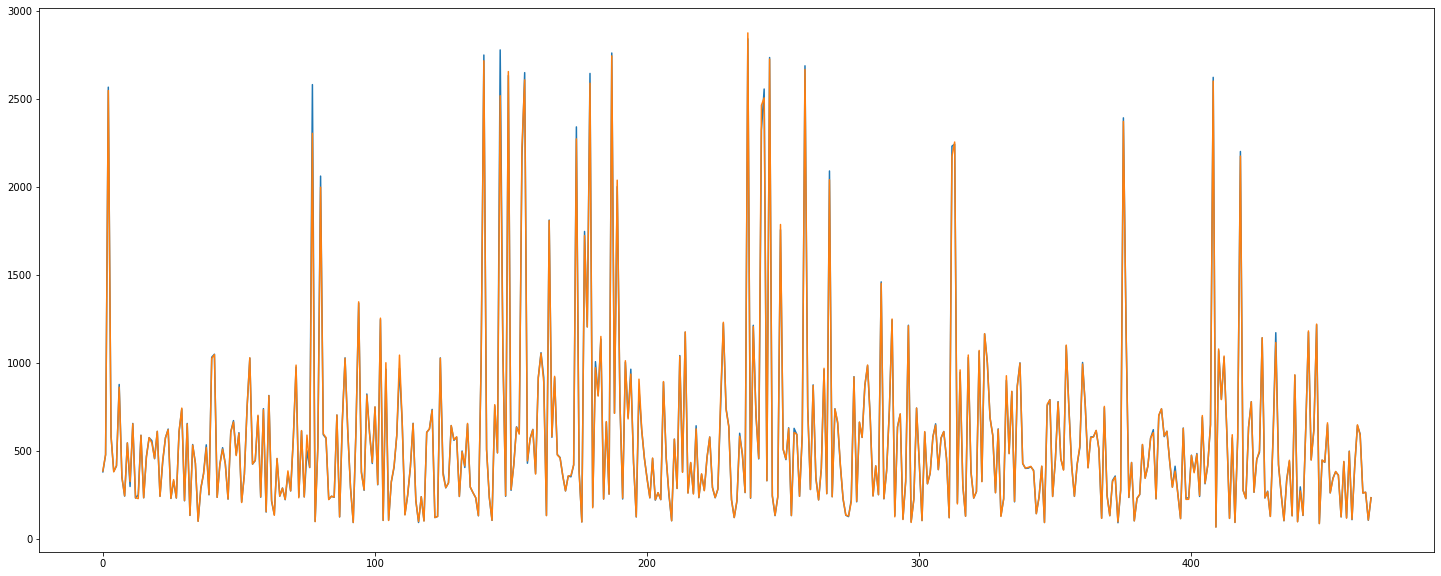

In [337]:
temp=[]
for i in range(467):
  temp.append(i)
plt.figure(figsize=[25,10])
plt.plot(temp,pred_lin)
plt.plot(temp,y_test)

plt.show